In [183]:
# Task1. 데이터 준비하기
import zipfile
import requests

url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
r = requests.get(url)
open("movie.zip", "wb").write(r.content)
zipfile.ZipFile("movie.zip").extractall()

In [184]:
# Task 1-1
import pandas as pd 

rating_data = pd.read_csv('ml-latest-small/ratings.csv')
# ratings.csv 파일을 train, test data로 나누기
# random_state 설정시 결과 고정
rating_train = rating_data.sample(frac=0.8, random_state=2021).sort_index()
rating_test = rating_data.drop(rating_train.index).sort_index()
rating_data

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [185]:
# Task 1-2
movie_data = pd.read_csv('ml-latest-small/movies.csv')

def str_to_set(x):
    genre_set = set()
    x_lst = x.split("|")
    for item in x_lst:
        genre_set.add(item)
    return genre_set
# movies.csv 파일의 genres를 집합으로 변환
movie_data.genres = movie_data.genres.apply(str_to_set)

In [186]:
# Task 1-3
tag_data = pd.read_csv('ml-latest-small/tags.csv')

def str_to_lower(x):
    return x.lower()

# tags.csv 파일의 tag들을 소문자로 변환
tag_data.tag = tag_data.tag.apply(str_to_lower)

# tag 데이터를 movieId로 묶고, tag들을 집합으로 변환
movie_tag = tag_data.groupby('movieId').agg(tag=('tag', set)).reset_index()

In [187]:
# Task2. Latent Factor 모델을 이용하여 학습하기
# Task 2-1
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

items = torch.LongTensor(rating_train['movieId'])
users = torch.LongTensor(rating_train['userId'])
ratings = torch.FloatTensor(rating_train['rating'])

items_test = torch.LongTensor(rating_test['movieId'].values)
users_test = torch.LongTensor(rating_test['userId'].values)
ratings_test = torch.FloatTensor(rating_test['rating'].values)

rank = 10
numItems = items.max() + 1
numUsers = users.max() + 1

P = torch.randn(numItems, rank, requires_grad = True)
Q = torch.randn(numUsers, rank, requires_grad = True)

In [188]:
# regularization, bias 추가 
lambda1 = 0.0001
lambda2 = 0.0001
lambda3 = 0.001
lambda4 = 0.001

bias_item = torch.randn(numItems, requires_grad = True)
bias_user = torch.randn(numUsers, requires_grad=True)
mean = (ratings.sum() / len(ratings)).item()

optimizer = torch.optim.Adam([P,Q, bias_item, bias_user], lr=0.5)     #lr 값 변경

X = []
Y = []
Y_test = []

for epoch in range(1001):
    hypothesis = torch.sum(P[items] * Q[users], dim=1) + mean + bias_item[items] + bias_user[users]
    cost = F.mse_loss(hypothesis, ratings)  
    train_rmse = math.sqrt(cost)
    loss = cost + lambda1 * torch.sum(P**2) + lambda2 * torch.sum(Q**2) + lambda3 * torch.sum(bias_item ** 2) + lambda4 * torch.sum(bias_user ** 2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        X.append(epoch)
        Y.append(train_rmse)

        hypo_test = torch.sum(P[items_test] * Q[users_test], dim=1) + mean + bias_item[items_test] + bias_user[users_test]
        test_rmse = math.sqrt(F.mse_loss(hypo_test, ratings_test))
        Y_test.append(test_rmse)
        if epoch % 100 == 0:
            print("epoch: {}, cost: {:.6f}, train_rmse: {:.6f}, test_rmse: {:.6f}".format(epoch, cost, train_rmse, test_rmse))

epoch: 0, cost: 12.750553, train_rmse: 3.570792, test_rmse: 2.026247
epoch: 100, cost: 0.415166, train_rmse: 0.644334, test_rmse: 0.877909
epoch: 200, cost: 0.408238, train_rmse: 0.638935, test_rmse: 0.877257
epoch: 300, cost: 0.407346, train_rmse: 0.638237, test_rmse: 0.877966
epoch: 400, cost: 0.407787, train_rmse: 0.638582, test_rmse: 0.878581
epoch: 500, cost: 0.406839, train_rmse: 0.637839, test_rmse: 0.879602
epoch: 600, cost: 0.406757, train_rmse: 0.637775, test_rmse: 0.879809
epoch: 700, cost: 0.407868, train_rmse: 0.638645, test_rmse: 0.879926
epoch: 800, cost: 0.407512, train_rmse: 0.638367, test_rmse: 0.878595
epoch: 900, cost: 0.410000, train_rmse: 0.640313, test_rmse: 0.879586
epoch: 1000, cost: 0.409111, train_rmse: 0.639617, test_rmse: 0.879001


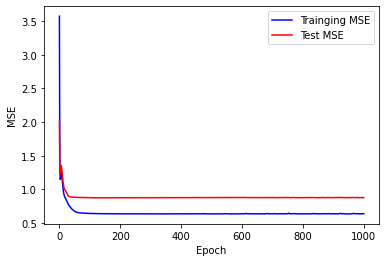

In [189]:
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.plot(X, Y, c="blue", label="Trainging MSE")
plt.plot(X, Y_test, c="red", label="Test MSE")
plt.legend()
plt.show()

In [136]:
# Task 3. 514번 User에게 추천하기
# Task 3-1
new_rating = rating_data[['userId', 'movieId', 'rating']]

# 테이블 -> 딕셔너리
def make_dict(dp):
    if len(dp.columns) == 1:
        if dp.values.size == 1: 
            return dp.values[0][0]
        return dp.values.squeeze()
    user = dp.groupby(dp.columns[0])
    new_dict = {x: make_dict(y.iloc[:, 1:]) for x, y in user}
    return new_dict

df_dict = make_dict(new_rating)

In [161]:
user_data = []
movies = []

for user in df_dict:
    user_data.append(user)
    for movie in df_dict[user]:
        if not movie in movies:
            movies.append(movie)

rating_data = {'userId': [], 'movieId': [], 'rating': []}

for user in df_dict:
    for movie in df_dict[user]:
        rating_data['userId'].append(user_data.index(user))
        rating_data['movieId'].append(movies.index(movie))
        rating_data['rating'].append(df_dict[user][movie])
        
df = pd.DataFrame(rating_data)

In [162]:
pip install surprise

In [174]:
import surprise
read_data = surprise.Reader(rating_scale=(0.0, 5.0))
columns = ['userId', 'movieId', 'rating']
read_data = surprise.Dataset.load_from_df(new_rating[columns], read_data)

train_data = read_data.build_full_trainset()
nn = surprise.KNNBasic()
nn.fit(train_data)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [182]:
recommand_data = {'userId': [], 'movieId': []}

for user_id in new_rating['userId'].unique():
    idx = user_data.index(user_id)
    result = nn.get_neighbors(idx, k=4)
    recom = set()
    for i in result:
        rating_meta = read_data.df[read_data.df['userId'] == user_data[i]]
        rating = rating_meta['rating'].max()
        movie_meta = read_data.df[(read_data.df['rating'] == rating) & (read_data.df['userId'] == user_data[i])] 
        movies = movie_meta['movieId'].values
        for movie in movies: 
            recom.add(movie)
        for movie_id in recom:
            recommand_data['userId'].append(user_id)
            recommand_data['movieId'].append(movie_id)

recommand_df = pd.DataFrame(recommand_data)
movie_list = recommand_df.loc[recommand_df['userId'] == 514, 'movieId'].unique()

re_movie = []
for i in movie_list:
    dp = movie_data.loc[movie_data['movieId']==i, 'title'].unique()
    re_movie.append([i, dp[0]])

# 영화와 아이디 출력
for id, title in re_movie[:20]:
    print(id ,title)

898 Philadelphia Story, The (1940)
3972 Legend of Drunken Master, The (Jui kuen II) (1994)
2150 Gods Must Be Crazy, The (1980)
59784 Kung Fu Panda (2008)
2924 Drunken Master (Jui kuen) (1978)
1019 20,000 Leagues Under the Sea (1954)
3996 Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)
222 Circle of Friends (1995)
2605 Entrapment (1999)
1267 Manchurian Candidate, The (1962)
2571 Matrix, The (1999)
527 Schindler's List (1993)
79132 Inception (2010)
109487 Interstellar (2014)
1200 Aliens (1986)
4022 Cast Away (2000)
168252 Logan (2017)
1097 E.T. the Extra-Terrestrial (1982)
2028 Saving Private Ryan (1998)
139385 The Revenant (2015)


In [9]:
# Task 3-2
import numpy as np
# tag와 장르가 있는 rating 데이터 (514 유저의 평점도 포함)
ratings = pd.merge(rating_data, movie_data, on='movieId', how='inner')
ratings = pd.merge(ratings, movie_tag, on='movieId', how='inner')

# 514 유저가 평점을 매긴 rating 데이터
ratings_514 = ratings.loc[ratings['userId'] == 514, :]
ratings_514 = ratings_514.loc[ratings_514['rating'] == 5.0, :].reset_index()

matrix = ratings.pivot_table(index='userId', columns='title', values='rating')

In [10]:
def jaccard_similarity(s1,s2):
    if len(s1|s2) == 0: return 0
    return len(s1&s2)/len(s1|s2)

def pearson_similarity(u1, u2):
    u1_c = u1 - u1.mean()
    u2_c = u2 - u2.mean()
    denom = np.sqrt(np.sum(u1_c**2) * np.sum(u2_c**2))
    if denom != 0:
        return np.sum(u1_c * u2_c)/denom
    else:
        return 0

def find_similar_movies(input_title, matrix, n, alpha):
    input_meta = ratings.loc[ratings['title'] == input_title].iloc[0]
    input_set = input_meta.genres | input_meta.tag
    
    result = []
    
    for this_title in matrix.columns:
        if this_title == input_title:
            continue
        
        this_meta = ratings.loc[ratings['title'] == this_title].iloc[0]
        this_movieId = this_meta['movieId']
        this_set = this_meta.genres | this_meta.tag
        
        pearson = pearson_similarity(matrix[this_title], matrix[input_title])
        jaccard = jaccard_similarity(this_set, input_set)
        
        score = alpha * pearson + (1-alpha)*jaccard
        result.append((this_movieId, this_title, score))
        
    result.sort(key=lambda r: r[2], reverse=True)
    
    return result[:n]

# 514번 유저 데이터의 영화 타이틀
title_lst = []
for i in range(len(ratings_514)):
    dp = ratings_514.iloc[i]
    title_lst.append([dp['movieId'], dp['title']])

for title in title_lst:
    result = find_similar_movies(title[1], matrix, 5, 0.3)
    print(title[0], title[1])
    result = pd.DataFrame(result, columns = ['movieId','title', 'score'])
    print(result)
    print("\n")


260 Star Wars: Episode IV - A New Hope (1977)
   movieId                                              title     score
0     1210  Star Wars: Episode VI - Return of the Jedi (1983)  0.359909
1     1196  Star Wars: Episode V - The Empire Strikes Back...  0.352121
2    33493  Star Wars: Episode III - Revenge of the Sith (...  0.189717
3     1200                                      Aliens (1986)  0.178861
4    68358                                   Star Trek (2009)  0.154692


593 Silence of the Lambs, The (1991)
   movieId               title     score
0     4725    Session 9 (2001)  0.269751
1     8957          Saw (2004)  0.225013
2     6323     Identity (2003)  0.216713
3       22      Copycat (1995)  0.209653
4      628  Primal Fear (1996)  0.208856


1196 Star Wars: Episode V - The Empire Strikes Back (1980)
   movieId                                              title     score
0      260          Star Wars: Episode IV - A New Hope (1977)  0.352121
1     1210  Star Wars: Episode V

In [54]:
# Task 4. 영화 클러스터링 하기
# Task 4-1
# k-means using sklearn
import random
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity


q_points = Q.detach().numpy()
cosine_p = cosine_similarity(q_points)
cost = []

# kmeans 실행
def kmeans(x):
    for i in range(1,41):  #k값은 1~40
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(x)
        cost.append(kmeans.inertia_ * 0.1)

kmeans(cosine_p)

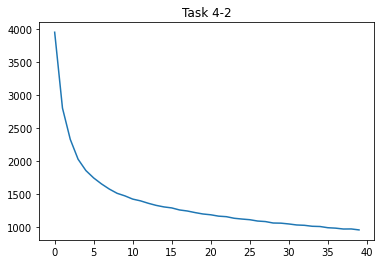

In [48]:
# Task 4-2
plt.title("Task 4-2")
plt.plot(range(40), cost)
plt.show()

In [60]:
# Task 5. 차원 축소 및 시각화
# Task 5-1

# P [9724, 10]
# Q [611, 10]
P = P.detach().numpy()
# P를 rating에 한번이라도 등장한 값들로 줄이기
P = P[rating_data['movieId'].unique()]
P = torch.Tensor(P)

# P와 Q를 합쳐서 Z 만들기
Z = torch.cat([P,Q], dim=0)
Z.size()

torch.Size([10335, 10])

In [61]:
# Task 5-2
def findPC(Z):
    w = torch.randn(Z.shape[1])
    # w는 단위벡터
    w = w/(torch.dot(w,w)**0.5)
    lr = 0.1
    for epoch in range(1001):
        w.requires_grad_(True)
        variance = torch.mean(torch.sum(Z * w, dim=1) ** 2)
        variance.backward(retain_graph=True)
        with torch.no_grad():
            w = w + lr * w.grad
            w = w/(torch.dot(w,w)**0.5)
    return w, variance.item()

def PCA(Z, n):
    W, V = [], []

    for _ in range(n):
        w, v = findPC(Z)
        W.append(w)
        V.append(v)
        Z = Z - (Z@w.view(-1,1)) * w
    
    return W, V

def transform(Z, W):
    return Z@torch.stack(W).T

W, V = PCA(Z, 2)
Zp = transform(Z, W)  #Zp.size =  [10335, 2]

In [70]:
Zp = Zp.detach().numpy()

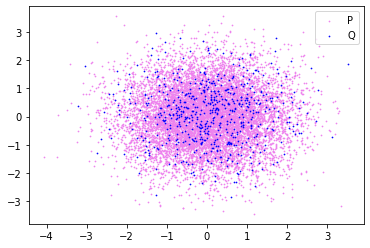

In [75]:
# Task 5-3-1
plt.scatter(Zp[:9724,0], Zp[:9724, 1], s=0.5, color='violet', label='P')
plt.scatter(Zp[9724:,0], Zp[9724:, 1], s=0.5, color='blue', label='Q')
plt.legend(loc="upper right")
plt.show()